# Policy Gradient for Playing Atari Enduro

**Disclaimer**: This notebook was executed using Google Colab's T4 GPU Python environment on May 2024. Since the gym environment has been deprecated and moved to gymnasium, the execution runtime of this notebook may differ from the output if it is run in the future.

First, we install the necessary packages to run gym's Atari environment.

In [1]:
!pip install gym[atari] gym[accept-rom-license] tensorboardx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 18.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446659 sha256=9394f3097f175b30a51e6f0106a9fbe977f924ebc3926c2ac0430044341a415c
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


## Environment

We import the deep learning packages and initialize a manual seed.

In [2]:
from gym.wrappers import (
    RecordVideo,
    RecordEpisodeStatistics,
    GrayScaleObservation,
    FrameStack,
    TransformReward,
    AtariPreprocessing,
)
import gym
import cv2
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F

%matplotlib inline

# set manual seed
seed = 2339

torch.manual_seed(seed)
np.random.seed(seed)

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Next, we define some preprocessing functions to optimize the learning process of the agent. Some of these preprocessing follows the recommendation from Machado et al. (2017):
- Use frameskip 4
- Resize the observation into 4x84x84
- Use grayscale pixel (0-255 => 0-1)

This code is inspired from [RL-Enduro wrapper](https://github.com/YimingQiao/RL-Enduro/blob/main/deeprl_hw2/wrappers.py).

In [3]:
import gym
import os
import warnings
import time

warnings.filterwarnings("ignore")


# create output folder
def get_output_folder(parent_dir, name):
    parent_dir = os.path.join(parent_dir, name)
    parent_dir = parent_dir + time.strftime("-%m-%d-%H-%M")

    os.makedirs(parent_dir, exist_ok=True)
    return parent_dir


def always_true(x):
    return True


class RepeatActionInFramesTakeMaxOfTwo(gym.Wrapper):
    def __init__(self, env, h=160, repeat=4):
        super().__init__(env)

        self.repeat = repeat
        self.h = h
        self.shape = (
            h,
            env.observation_space.low.shape[1],
            env.observation_space.low.shape[2],
        )
        self.frames = deque(maxlen=2)

        if repeat <= 0:
            raise ValueError("Repeat value needs to be 1 or higher")

    def step(self, action):
        total_reward = 0
        done = False
        info = {}

        for i in range(self.repeat):
            observation, reward, done, info = self.env.step(action)
            total_reward += reward
            self.frames.append(observation[: self.h, :, :])

            if done:
                break

        # Open queue into arguments for np.maximum
        maximum_of_frames = np.maximum(*self.frames)
        return maximum_of_frames, total_reward, done, info

    def reset(self):
        observation = self.env.reset()
        self.frames.clear()
        self.frames.append(observation[: self.h, :, :])
        return observation[: self.h, :, :]


class NormResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)

        # Create the new observation space for the env
        # Since we are converting to grayscale we set low of 0 and high of 1
        self.shape = shape

        self.observation_space = gym.spaces.Box(
            low=0.0, high=1.0, shape=self.shape, dtype=np.float32
        )

    def observation(self, observation):
        """Change from 255 grayscale to 0-1 scale"""
        observation = cv2.resize(observation, self.shape, interpolation=cv2.INTER_AREA)
        return (observation / 255.0).reshape(self.shape)


class ClipRewardWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)

    def reward(self, reward):
        def clip(x):
            if x < 0:
                return -1
            if x > 0:
                return 1
            return 0

        vec_clip = np.vectorize(clip)
        return vec_clip(reward)


def Wrap(env, video_dir):
    shape = (84, 84)
    env = RepeatActionInFramesTakeMaxOfTwo(env, repeat=4)
    env = ClipRewardWrapper(env)
    env = GrayScaleObservation(env)
    env = NormResizeObservation(env, shape)
    env = FrameStack(env, num_stack=4)
    env = RecordEpisodeStatistics(env, 100)
    env = RecordVideo(env, video_dir, episode_trigger=always_true)
    return env

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Training
We define a simple policy network for this vanilla policy gradient implementation. The model contains:
- Fully connected layer that converts 4x84x84 to 512 output features, ReLU activation, and dropout (0.1)
- Fully connected layer that converts 512 input features to 256 output features, ReLU activation, and dropout (0.1)
- Final fully connected layer that outputs 9 features, each represented the action for Enduro game


In [4]:
class PolicyPi(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.hidden = nn.Linear(84 * 84 * 4, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim // 2)
        # 9 is number of action in Enduro
        self.output = nn.Linear(hidden_dim // 2, 9)
        self.dropout = nn.Dropout(0.1)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        outs = self.dropout(outs)
        outs = self.hidden2(outs)
        outs = F.relu(outs)
        outs = self.dropout(outs)
        logits = self.output(outs)
        return logits


policy_pi = PolicyPi(hidden_dim=512).to(device)

Next, we initialize the gym environment. We call the wrapper function to preprocess the observation.

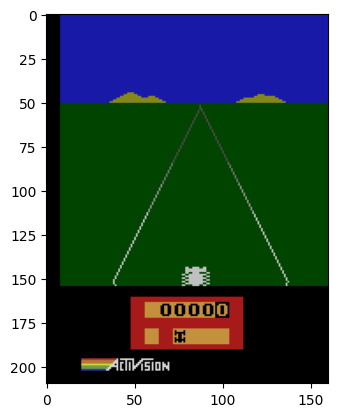

In [5]:
env = gym.make("ALE/Enduro-v5")
output_dir = get_output_folder("gym_monitor", "PG")
env = Wrap(env, output_dir)

env.reset()
plt.imshow(env.render(mode="rgb_array"))

Finally, we can start the training process. We perform a 300 episodes training. In each episode, we will pick the action by sampling the output logits. This means, we need to convert the output logits into a probability distribution using `softmax`.

We update the network by taking the negative log probability of the actions and multiply by the rewards.

For the policy gradient update, we choose this parameters:
- Gamma (discount factor) = `0.99`
- Optimizer = ADAM with learning rate of `1e-4`

This training code is inspired by [vanilla PG](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/02-policy-gradient.ipynb).

In [6]:
gamma = 0.99
max_reward = 0
max_episodes = 300


# Sample an action with the distribution from the policy
def pick_sample(s):
    with torch.no_grad():
        # Flatten observation
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        s_batch = torch.flatten(s_batch, start_dim=1)

        # Get logits from state
        logits = policy_pi(s_batch)
        logits = logits.squeeze(dim=0)

        # From logits to probability distribution
        probs = F.softmax(logits, dim=-1)

        # Sample
        a = torch.multinomial(probs, num_samples=1)
        return a.item()


# Define optimizer
reward_records = []
opt = torch.optim.Adam(policy_pi.parameters(), lr=1e-4)

for i in range(max_episodes):
    # Run episode until the game terminates
    done = False
    states = []
    actions = []
    rewards = []
    s = env.reset()
    while not done:
        states.append(s)
        a = pick_sample(s)
        s, r, term, _ = env.step(a)
        done = term
        actions.append(a)
        rewards.append(r)

    # Get cumulative rewards
    cum_rewards = np.zeros_like(rewards)
    reward_len = len(rewards)
    for j in reversed(range(reward_len)):
        cum_rewards[j] = rewards[j] + (
            cum_rewards[j + 1] * gamma if j + 1 < reward_len else 0
        )

    # Prepare trajectory (states and actions) from this episode
    states = torch.tensor(states, dtype=torch.float).to(device)
    states = states.flatten(start_dim=1)
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    cum_rewards = torch.tensor(cum_rewards, dtype=torch.float).to(device)

    # Training
    opt.zero_grad()

    # Calculate negative log probability (-log P) as loss.
    # Cross-entropy loss is -log P in categorical distribution
    logits = policy_pi(states)
    log_probs = -F.cross_entropy(logits, actions, reduction="none")
    loss = -log_probs * cum_rewards

    loss.sum().backward()
    opt.step()

    # Save total rewards
    print("Run episode {} with rewards {}".format(i, sum(rewards)))
    reward_records.append(sum(rewards))

    # Save model checkpoint
    if sum(rewards) > max_reward:
        max_reward = sum(rewards)
        torch.save(policy_pi.state_dict(), "policy_pi.pth")

print("Done")
env.close()

Run episode 0 with rewards 0
Run episode 1 with rewards 0
Run episode 2 with rewards 1
Run episode 3 with rewards 0
Run episode 4 with rewards 0
Run episode 5 with rewards 0
Run episode 6 with rewards 0
Run episode 7 with rewards 0
Run episode 8 with rewards 0
Run episode 9 with rewards 0
Run episode 10 with rewards 0
Run episode 11 with rewards 0
Run episode 12 with rewards 0
Run episode 13 with rewards 0
Run episode 14 with rewards 0
Run episode 15 with rewards 0
Run episode 16 with rewards 0
Run episode 17 with rewards 0
Run episode 18 with rewards 0
Run episode 19 with rewards -1
Run episode 20 with rewards 0
Run episode 21 with rewards -1
Run episode 22 with rewards 0
Run episode 23 with rewards 0
Run episode 24 with rewards 0
Run episode 25 with rewards 0
Run episode 26 with rewards -1
Run episode 27 with rewards 0
Run episode 28 with rewards 0
Run episode 29 with rewards 2
Run episode 30 with rewards 7
Run episode 31 with rewards -4
Run episode 32 with rewards -1
Run episode 33 

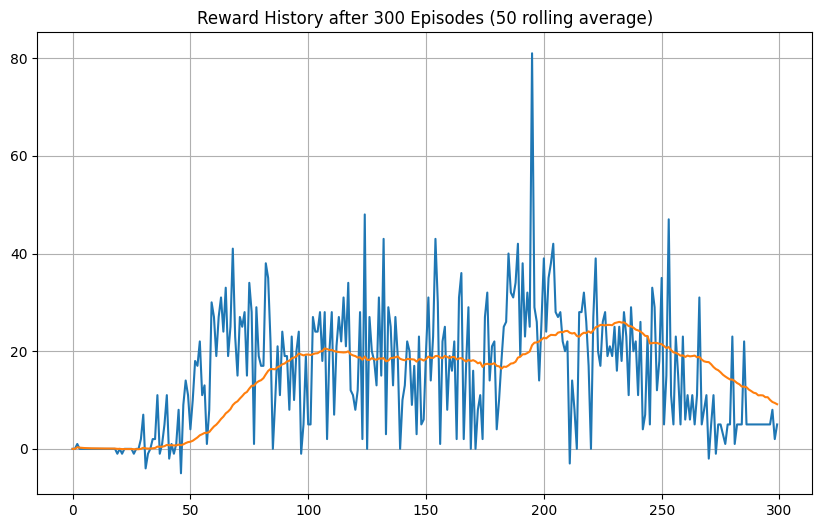

In [7]:
# Generate recent 50 rolling average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        # Take average from the beginning
        avg_list = reward_records[: idx + 1]
    else:
        # Take the last 50 rewards
        avg_list = reward_records[idx - 49 : idx + 1]
    average_reward.append(np.average(avg_list))

# Plot
plt.figure(figsize=(10, 6))
plt.title("Reward History after 300 Episodes (50 rolling average)")
plt.plot(reward_records)
plt.plot(average_reward)
plt.grid()
plt.show()

## Concluding Remarks
After doing 300 episodes, we achieved a highest reward of 80. While the score is not that impressive, we demonstrated that it is possible to train a simple network to play Enduro. The reward graph is unstable as it showed a decrease even in higher episodes. This should be expected because the vanilla policy gradient samples the action and training trajectory after each episodes, leading to a very random outcome of rewards.